In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.defs.tdc_data_analysis import line_hist

**TODO**: Update wherever possible from pandas frames to numpy

In [2]:
def preproces_tdcs(filename=None,debug=False,tdc_df=None):
    ''' 
    Args:
        filename : string
            name of the file
        debug : bool
              if True returns all dataframes
        tdc_df : pd.DataFrame Object
            instead of reading from file one can give the df directly
    Returns:
        time_df : pd.DataFrame Object
            
    It takes the data file for TDC's ONLY, which is assumed to be in the form
    TDCn: t0.
    We first seperate TDC's apart and then merge them, which creates nulls.
    The nulls for TDC2 are back filled i.e. if a cell N is null then it's filled 
    with the last cell <N which isn't null. TDC1 nulls aren't filled but rather dropped
    because we are really interested in TDC2. Finally we calculate the time difference
    between TD1 and TDC2. Finally we gate the difference by 5*10^4 ns = 50 us.
    '''
    if filename is not None:
        tpx_df =pd.read_csv(filename,
                    sep=':',
                    error_bad_lines=False,
                    warn_bad_lines=False,
                    header=None)
    elif tdc_df is not None:
        tpx_df = tdc_df
    else:
        raise(Exception('Either a filename or a tdc data frame needs to be given!'))
    tpx_df.columns = ['tdc','time']

    print('tpx_df nulls\n',tpx_df.isna().sum())
    tdc_one = tpx_df[tpx_df.tdc == 'TDC1']
    tdc_two = tpx_df[tpx_df.tdc == 'TDC2']
    time_df = tdc_one[['time']].join(tdc_two.time,how='outer',lsuffix='1',rsuffix='2')
    time_df['time2'] = time_df['time2'].fillna(method='bfill')
    time_df['time1'] = time_df['time1'].fillna(method='bfill')

    #time_df.dropna(inplace=True)
    time_df = time_df.astype(np.float64)
    time_df['delta_t'] = (time_df.time2-time_df.time1)*1e9
    time_df.reset_index(inplace=True)
    time_df.drop('index',axis=1,inplace=True)
    #time_df = time_df[np.abs(time_df.delta_t)< 5e3]
    if debug:
        return tpx_df, tdc_one, tdc_two, time_df
    else:
        print(time_df.head(10))
        return time_df

In [23]:
def final_processing(df_str,debug=False):
    if debug:
        tpx_data = df_str
    else:
        tpx_data = pd.read_csv(StringIO(df_str),index_col=False)
    tpx_data['totx'] = tpx_data['tot']*tpx_data['x']
    tpx_data['toty'] = tpx_data['tot']*tpx_data['y']
    tpx_data['delta_t'] = (tpx_data['tdc2']-tpx_data['tdc1'])
    tpx_data['ones'] =1
    batches = tpx_data.groupby('batch').sum()
    batches['delta_t'] = batches['delta_t']/batches['ones']
    batches['x'] = batches['totx']/batches['tot']
    batches['y'] = batches['toty']/batches['tot']
    batches.drop(['toa','tot','tdc1','tdc2','totx','toty','ones'],axis=1,inplace=True)
    if debug:
        return batches
    return batches.to_csv(header=False)

In [24]:
from io import StringIO

tpx_df nulls
 tdc     0
time    0
dtype: int64
5_000 batches were rejected due time gating
1_000_000 lines read
100_000 lines were rejected due to tdc2 mismatch

Batch numer 2_000 is written
1_166_190 lines read
-----
10_000 batches were rejected due time gating


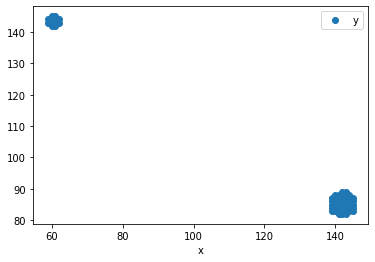

15_000 batches were rejected due time gating
2_000_000 lines read
200_000 lines were rejected due to tdc2 mismatch

Batch numer 4_000 is written
2_370_745 lines read
-----
20_000 batches were rejected due time gating


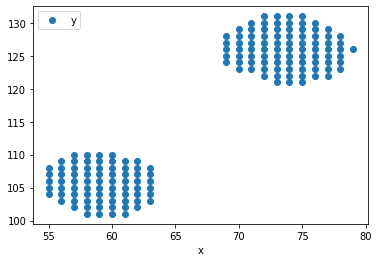

3_000_000 lines read
100_000 lines were rejected due to tdc1 mismatch
25_000 batches were rejected due time gating
### TOA Overflow NO 1
toa_prev 26.8432881046875 toa 26.844766946874998 tdc1 26.8432837567688 tdc2 26.8432885492187
300_000 lines were rejected due to tdc2 mismatch

Batch numer 6_000 is written
3_559_369 lines read
-----
30_000 batches were rejected due time gating
4_000_000 lines read
35_000 batches were rejected due time gating
400_000 lines were rejected due to tdc2 mismatch

Batch numer 8_000 is written
4_790_296 lines read
-----
40_000 batches were rejected due time gating
5_000_000 lines read


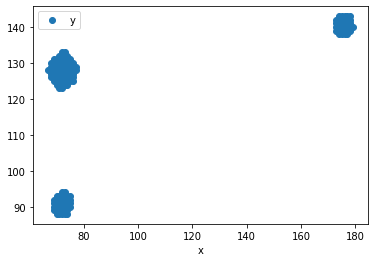

45_000 batches were rejected due time gating
500_000 lines were rejected due to tdc2 mismatch
200_000 lines were rejected due to tdc1 mismatch

Batch numer 10_000 is written
5_982_776 lines read
-----
50_000 batches were rejected due time gating
6_000_000 lines read
55_000 batches were rejected due time gating
### TOA Overflow NO 2
toa_prev 53.6860586046875 toa 53.6870919171875 tdc1 53.686054253125 tdc2 53.686059040625
5_000 physical batches were                                   rejected due to many electrons
600_000 lines were rejected due to tdc2 mismatch
7_000_000 lines read

Batch numer 12_000 is written
7_176_967 lines read
-----
60_000 batches were rejected due time gating
65_000 batches were rejected due time gating
8_000_000 lines read
700_000 lines were rejected due to tdc2 mismatch

Batch numer 14_000 is written
8_387_363 lines read
-----
70_000 batches were rejected due time gating
300_000 lines were rejected due to tdc1 mismatch
9_000_000 lines read
75_000 batches were rej

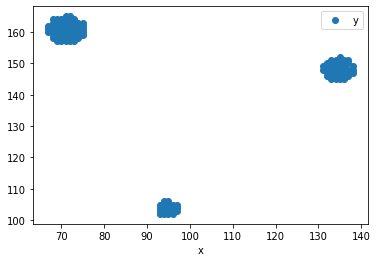

800_000 lines were rejected due to tdc2 mismatch


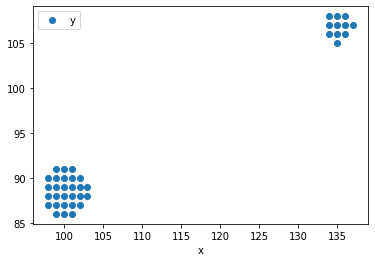

80_000 batches were rejected due time gating

Batch numer 16_000 is written
9_616_042 lines read
-----
10_000_000 lines read
### TOA Overflow NO 3
toa_prev 80.529615959375 toa 80.53076879062499 tdc1 80.5296271729126 tdc2 80.5294288893188
85_000 batches were rejected due time gating
900_000 lines were rejected due to tdc2 mismatch

Batch numer 18_000 is written
10_801_986 lines read
-----
90_000 batches were rejected due time gating


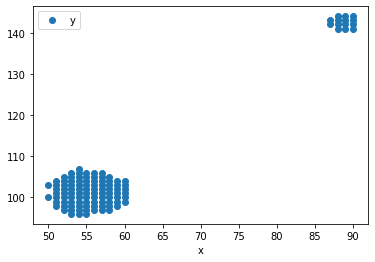

11_000_000 lines read
95_000 batches were rejected due time gating
1_000_000 lines were rejected due to tdc2 mismatch
400_000 lines were rejected due to tdc1 mismatch
100_000 batches were rejected due time gating
12_000_000 lines read

Batch numer 20_000 is written
12_025_313 lines read
-----
105_000 batches were rejected due time gating
1_100_000 lines were rejected due to tdc2 mismatch
13_000_000 lines read
110_000 batches were rejected due time gating

Batch numer 22_000 is written
13_225_301 lines read
-----
### TDC2 Overflow NO 1
tdc2 107.372405525519 tdc2_next 107.37467885468749 tdc1 107.371344810156 toa 107.3723913265625
### TOA Overflow NO 4
toa_prev 107.3732297453125 toa 107.3746785125 tdc1 107.373225389319 tdc2 107.372405525519
### TDC1 Overflow NO 1
tdc1 107.374165678644 tdc1_next 107.3751059682251 tdc2 107.37467885468749 toa 107.3746785125
10_000 physical batches were                                   rejected due to many electrons


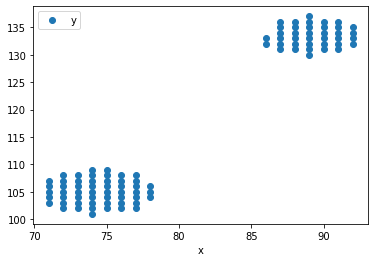

115_000 batches were rejected due time gating
1_200_000 lines were rejected due to tdc2 mismatch
14_000_000 lines read
120_000 batches were rejected due time gating

Batch numer 24_000 is written
14_491_086 lines read
-----
500_000 lines were rejected due to tdc1 mismatch
15_000_000 lines read
125_000 batches were rejected due time gating
1_300_000 lines were rejected due to tdc2 mismatch
130_000 batches were rejected due time gating

Batch numer 26_000 is written
15_725_893 lines read
-----
16_000_000 lines read
1_400_000 lines were rejected due to tdc2 mismatch
135_000 batches were rejected due time gating


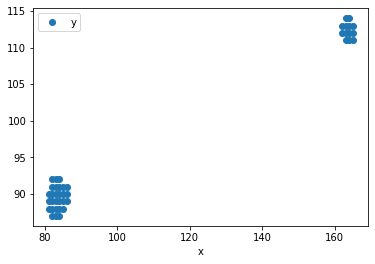

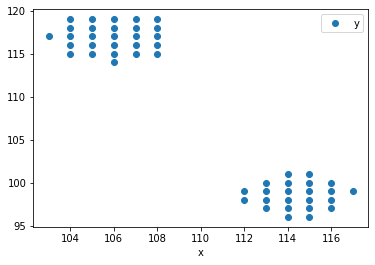

140_000 batches were rejected due time gating


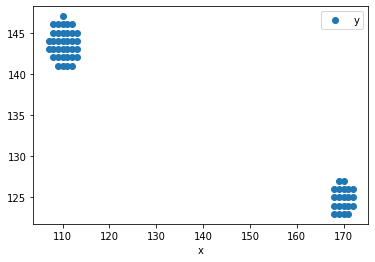


Batch numer 28_000 is written
16_999_959 lines read
-----
17_000_000 lines read
### TOA Overflow NO 5
toa_prev 134.2176698828125 toa 134.2184914734375 tdc1 134.21770172291258 tdc2 134.21767029765618


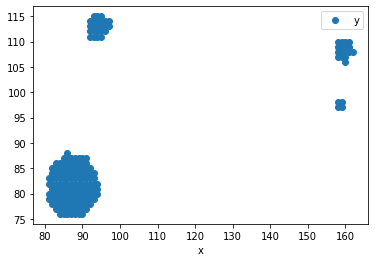

1_500_000 lines were rejected due to tdc2 mismatch
145_000 batches were rejected due time gating
600_000 lines were rejected due to tdc1 mismatch
150_000 batches were rejected due time gating
18_000_000 lines read

Batch numer 30_000 is written
18_223_465 lines read
-----
1_600_000 lines were rejected due to tdc2 mismatch
155_000 batches were rejected due time gating
19_000_000 lines read
160_000 batches were rejected due time gating

Batch numer 32_000 is written
19_474_356 lines read
-----
1_700_000 lines were rejected due to tdc2 mismatch
165_000 batches were rejected due time gating


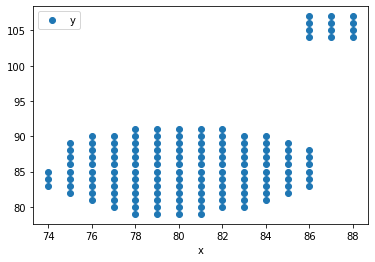

20_000_000 lines read
170_000 batches were rejected due time gating
700_000 lines were rejected due to tdc1 mismatch
### TOA Overflow NO 6
toa_prev 161.06071669375 toa 161.0613956 tdc1 161.0603990572876 tdc2 161.0605327471313

Batch numer 34_000 is written
20_717_663 lines read
-----
15_000 physical batches were                                   rejected due to many electrons
1_800_000 lines were rejected due to tdc2 mismatch
175_000 batches were rejected due time gating
21_000_000 lines read
180_000 batches were rejected due time gating
1_900_000 lines were rejected due to tdc2 mismatch

Batch numer 36_000 is written
21_964_023 lines read
-----
22_000_000 lines read
185_000 batches were rejected due time gating
190_000 batches were rejected due time gating
2_000_000 lines were rejected due to tdc2 mismatch
23_000_000 lines read


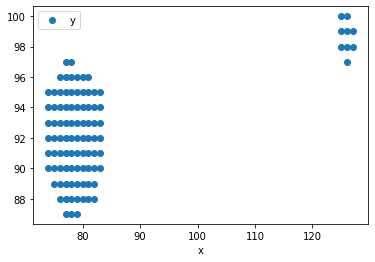


Batch numer 38_000 is written
23_242_593 lines read
-----
195_000 batches were rejected due time gating
800_000 lines were rejected due to tdc1 mismatch
200_000 batches were rejected due time gating
24_000_000 lines read
2_100_000 lines were rejected due to tdc2 mismatch
### TOA Overflow NO 7
toa_prev 187.904638953125 toa 187.9055133859375 tdc1 187.90399858255 tdc2 187.904639398175

Batch numer 40_000 is written
24_487_957 lines read
-----
205_000 batches were rejected due time gating
25_000_000 lines read


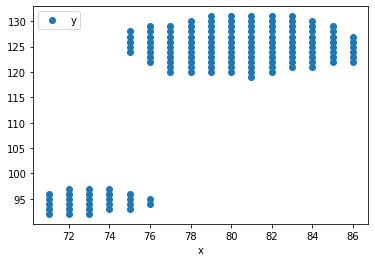

210_000 batches were rejected due time gating
2_200_000 lines were rejected due to tdc2 mismatch
215_000 batches were rejected due time gating

Batch numer 42_000 is written
25_741_879 lines read
-----
26_000_000 lines read
220_000 batches were rejected due time gating
900_000 lines were rejected due to tdc1 mismatch
2_300_000 lines were rejected due to tdc2 mismatch
225_000 batches were rejected due time gating


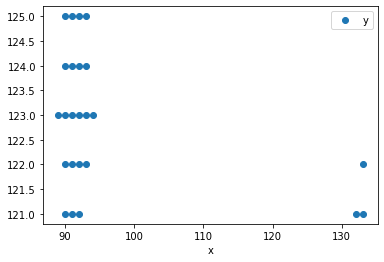


Batch numer 44_000 is written
26_997_206 lines read
-----
27_000_000 lines read
230_000 batches were rejected due time gating
2_400_000 lines were rejected due to tdc2 mismatch
### TDC2 Overflow NO 2
tdc2 214.747223045569 tdc2_next 214.74848888203124 tdc1 214.7447230526 toa 214.7472226578125
### TDC1 Overflow NO 2
tdc1 214.747543826819 tdc1_next 214.7484840927063 tdc2 214.747223045569 toa 214.7475482734375
### TOA Overflow NO 8
toa_prev 214.7482237921875 toa 214.7484885015625 tdc1 214.747543826819 tdc2 214.74848888203124
20_000 physical batches were                                   rejected due to many electrons
28_000_000 lines read
235_000 batches were rejected due time gating

Batch numer 46_000 is written
28_277_145 lines read
-----
240_000 batches were rejected due time gating
2_500_000 lines were rejected due to tdc2 mismatch
29_000_000 lines read
245_000 batches were rejected due time gating
1_000_000 lines were rejected due to tdc1 mismatch

Batch numer 48_000 is written
29_5

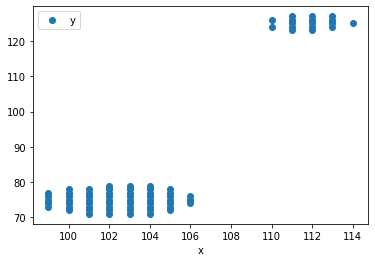

275_000 batches were rejected due time gating
33_000_000 lines read

Batch numer 54_000 is written
33_241_591 lines read
-----


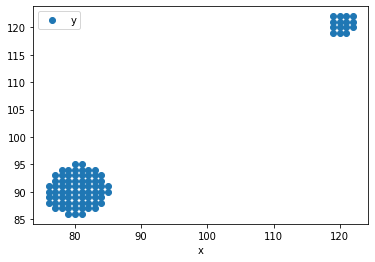

2_900_000 lines were rejected due to tdc2 mismatch
280_000 batches were rejected due time gating
34_000_000 lines read
285_000 batches were rejected due time gating

Batch numer 56_000 is written
34_490_052 lines read
-----
### TOA Overflow NO 10
toa_prev 268.4353778078125 toa 268.435687159375 tdc1 268.4347057057251 tdc2 268.4353782455688
3_000_000 lines were rejected due to tdc2 mismatch
290_000 batches were rejected due time gating
25_000 physical batches were                                   rejected due to many electrons
35_000_000 lines read
1_200_000 lines were rejected due to tdc1 mismatch
295_000 batches were rejected due time gating


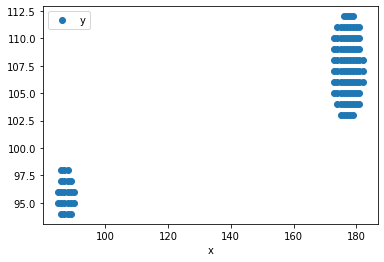


Batch numer 58_000 is written
35_714_053 lines read
-----
3_100_000 lines were rejected due to tdc2 mismatch
300_000 batches were rejected due time gating
36_000_000 lines read
305_000 batches were rejected due time gating
3_200_000 lines were rejected due to tdc2 mismatch

Batch numer 60_000 is written
36_988_128 lines read
-----
310_000 batches were rejected due time gating
37_000_000 lines read
315_000 batches were rejected due time gating
1_300_000 lines were rejected due to tdc1 mismatch
3_300_000 lines were rejected due to tdc2 mismatch
### TOA Overflow NO 11
toa_prev 295.2789614265625 toa 295.280051978125 tdc1 295.2783169807251 tdc2 295.27896187109377
38_000_000 lines read
320_000 batches were rejected due time gating

Batch numer 62_000 is written
38_213_989 lines read
-----
325_000 batches were rejected due time gating
39_000_000 lines read
3_400_000 lines were rejected due to tdc2 mismatch


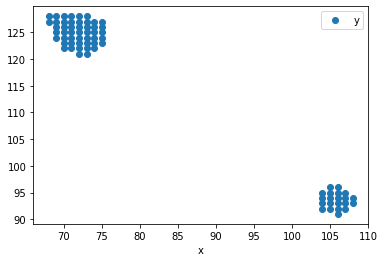

330_000 batches were rejected due time gating

Batch numer 64_000 is written
39_476_047 lines read
-----
335_000 batches were rejected due time gating
40_000_000 lines read
3_500_000 lines were rejected due to tdc2 mismatch
340_000 batches were rejected due time gating

Batch numer 66_000 is written
40_679_701 lines read
-----
1_400_000 lines were rejected due to tdc1 mismatch


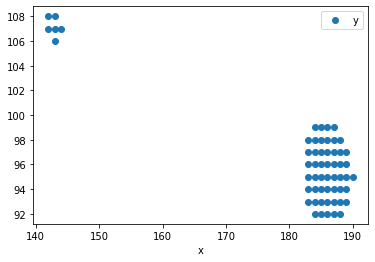

41_000_000 lines read
345_000 batches were rejected due time gating
3_600_000 lines were rejected due to tdc2 mismatch
### TDC2 Overflow NO 3
tdc2 322.121583936456 tdc2_next 322.1227852703125 tdc1 322.120899995312 toa 322.121583540625
### TDC1 Overflow NO 3
tdc1 322.1218402375 tdc1_next 322.1227804799438 tdc2 322.1227852703125 toa 322.1223701265625
### TOA Overflow NO 12
toa_prev 322.12237011718753 toa 322.122784890625 tdc1 322.1218402375 tdc2 322.1227852703125
350_000 batches were rejected due time gating

Batch numer 68_000 is written
41_919_571 lines read
-----
42_000_000 lines read
30_000 physical batches were                                   rejected due to many electrons


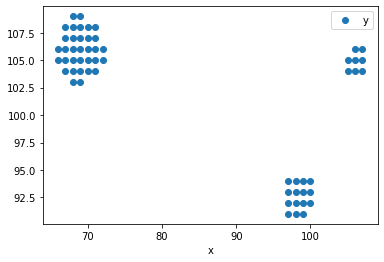

355_000 batches were rejected due time gating
3_700_000 lines were rejected due to tdc2 mismatch


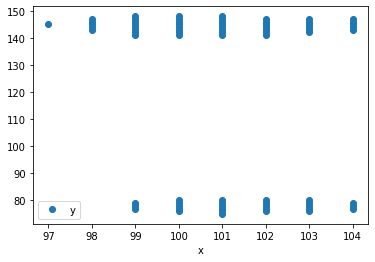

360_000 batches were rejected due time gating
43_000_000 lines read

Batch numer 70_000 is written
43_145_175 lines read
-----
365_000 batches were rejected due time gating
1_500_000 lines were rejected due to tdc1 mismatch
3_800_000 lines were rejected due to tdc2 mismatch
44_000_000 lines read
370_000 batches were rejected due time gating

Batch numer 72_000 is written
44_337_580 lines read
-----
375_000 batches were rejected due time gating
### TOA Overflow NO 13
toa_prev 348.96519926562496 toa 348.96624572656253 tdc1 348.9643607447876 tdc2 348.96519971328127
3_900_000 lines were rejected due to tdc2 mismatch
45_000_000 lines read
380_000 batches were rejected due time gating

Batch numer 74_000 is written
45_611_781 lines read
-----


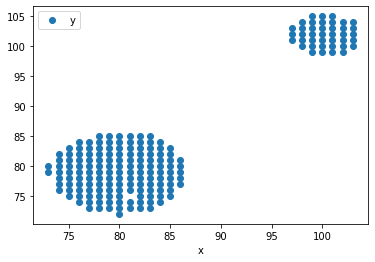

385_000 batches were rejected due time gating
46_000_000 lines read
4_000_000 lines were rejected due to tdc2 mismatch
390_000 batches were rejected due time gating
1_600_000 lines were rejected due to tdc1 mismatch

Batch numer 76_000 is written
46_856_389 lines read
-----
47_000_000 lines read
395_000 batches were rejected due time gating
4_100_000 lines were rejected due to tdc2 mismatch


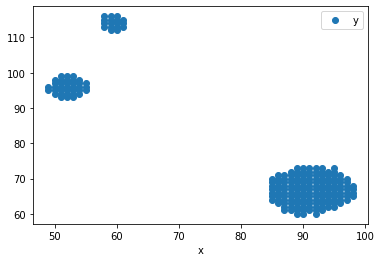

400_000 batches were rejected due time gating


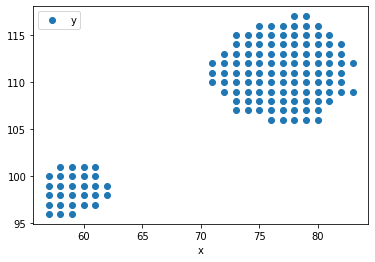

48_000_000 lines read

Batch numer 78_000 is written
48_097_955 lines read
-----


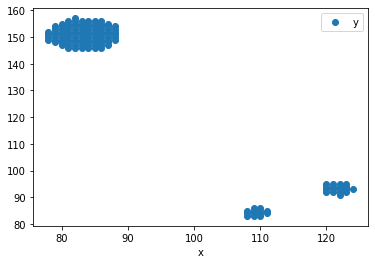

### TOA Overflow NO 14
toa_prev 375.8088105359375 toa 375.810338178125 tdc1 375.8085959494751 tdc2 375.8080836080688
405_000 batches were rejected due time gating
4_200_000 lines were rejected due to tdc2 mismatch
410_000 batches were rejected due time gating


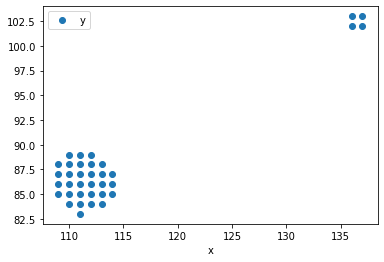

49_000_000 lines read
35_000 physical batches were                                   rejected due to many electrons

Batch numer 80_000 is written
49_332_524 lines read
-----
1_700_000 lines were rejected due to tdc1 mismatch
415_000 batches were rejected due time gating
4_300_000 lines were rejected due to tdc2 mismatch
50_000_000 lines read
420_000 batches were rejected due time gating

Batch numer 82_000 is written
50_568_659 lines read
-----
425_000 batches were rejected due time gating
4_400_000 lines were rejected due to tdc2 mismatch


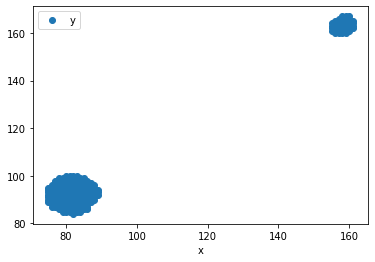

51_000_000 lines read
430_000 batches were rejected due time gating
### TOA Overflow NO 15
toa_prev 402.652864628125 toa 402.65325868749994 tdc1 402.6523139710937 tdc2 402.6532590390625

Batch numer 84_000 is written
51_791_324 lines read
-----
4_500_000 lines were rejected due to tdc2 mismatch
435_000 batches were rejected due time gating
52_000_000 lines read
1_800_000 lines were rejected due to tdc1 mismatch
440_000 batches were rejected due time gating
53_000_000 lines read

Batch numer 86_000 is written
53_007_103 lines read
-----
445_000 batches were rejected due time gating
4_600_000 lines were rejected due to tdc2 mismatch
450_000 batches were rejected due time gating
54_000_000 lines read

Batch numer 88_000 is written
54_172_589 lines read
-----


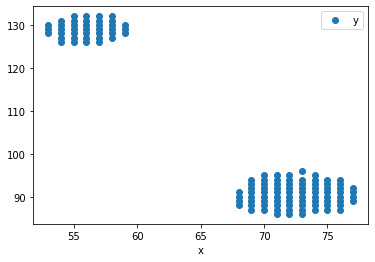

4_700_000 lines were rejected due to tdc2 mismatch
455_000 batches were rejected due time gating


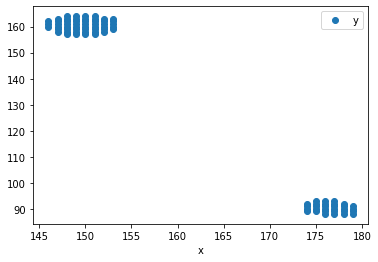

460_000 batches were rejected due time gating
55_000_000 lines read
### TDC2 Overflow NO 4
tdc2 429.49596691249997 tdc2_next 429.4968547380188 tdc1 429.494085420312 toa 429.4956351296875
### TDC1 Overflow NO 4
tdc1 429.495966022656 tdc1_next 429.49690632369385 tdc2 429.49596691249997 toa 429.49596652500003
### TOA Overflow NO 16
toa_prev 429.49596647343753 toa 429.49685438593747 tdc1 429.495966022656 tdc2 429.49596691249997
1_900_000 lines were rejected due to tdc1 mismatch

Batch numer 90_000 is written
55_409_249 lines read
-----
4_800_000 lines were rejected due to tdc2 mismatch
465_000 batches were rejected due time gating


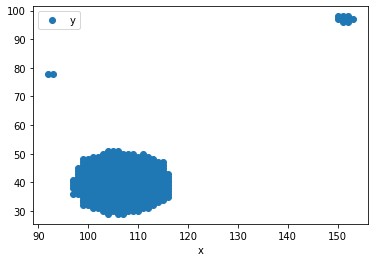

56_000_000 lines read
40_000 physical batches were                                   rejected due to many electrons
470_000 batches were rejected due time gating


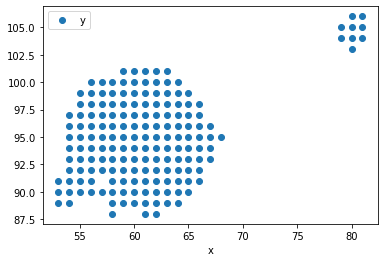

4_900_000 lines were rejected due to tdc2 mismatch

Batch numer 92_000 is written
56_626_954 lines read
-----
475_000 batches were rejected due time gating
57_000_000 lines read
480_000 batches were rejected due time gating
5_000_000 lines were rejected due to tdc2 mismatch

Batch numer 94_000 is written
57_844_551 lines read
-----
485_000 batches were rejected due time gating
58_000_000 lines read
2_000_000 lines were rejected due to tdc1 mismatch
490_000 batches were rejected due time gating
### TOA Overflow NO 17
toa_prev 456.3396248390625 toa 456.3404712421875 tdc1 456.33962049843745 tdc2 456.3396252880188
5_100_000 lines were rejected due to tdc2 mismatch
59_000_000 lines read
495_000 batches were rejected due time gating

Batch numer 96_000 is written
59_136_797 lines read
-----
500_000 batches were rejected due time gating
60_000_000 lines read
5_200_000 lines were rejected due to tdc2 mismatch
505_000 batches were rejected due time gating

Batch numer 98_000 is written
60_404_7

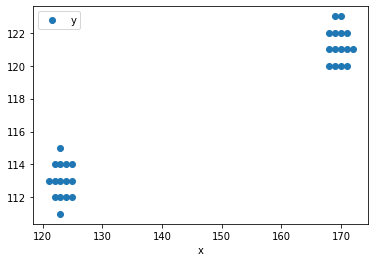

5_500_000 lines were rejected due to tdc2 mismatch
2_200_000 lines were rejected due to tdc1 mismatch
535_000 batches were rejected due time gating
64_000_000 lines read

Batch numer 104_000 is written
64_122_438 lines read
-----


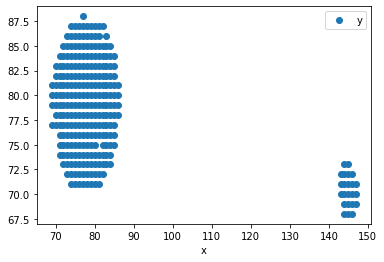

540_000 batches were rejected due time gating
5_600_000 lines were rejected due to tdc2 mismatch
65_000_000 lines read
545_000 batches were rejected due time gating

Batch numer 106_000 is written
65_334_619 lines read
-----
### TOA Overflow NO 19
toa_prev 510.0272774671875 toa 510.0279860828125 tdc1 510.02704129791255 tdc2 510.02727791614376
550_000 batches were rejected due time gating
5_700_000 lines were rejected due to tdc2 mismatch
66_000_000 lines read
555_000 batches were rejected due time gating

Batch numer 108_000 is written
66_527_688 lines read
-----
560_000 batches were rejected due time gating
2_300_000 lines were rejected due to tdc1 mismatch
67_000_000 lines read
5_800_000 lines were rejected due to tdc2 mismatch
565_000 batches were rejected due time gating

Batch numer 110_000 is written
67_731_327 lines read
-----
570_000 batches were rejected due time gating
68_000_000 lines read
5_900_000 lines were rejected due to tdc2 mismatch
575_000 batches were rejected due t

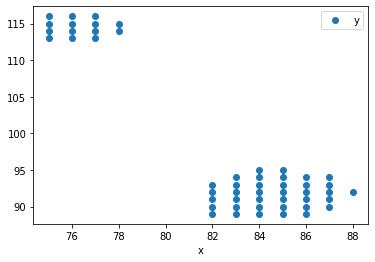


Batch numer 112_000 is written
68_953_042 lines read
-----
### TDC2 Overflow NO 5
tdc2 536.870564239062 tdc2_next 536.87133654375 tdc1 536.868694326819 toa 536.8705638390625
### TDC1 Overflow NO 5
tdc1 536.8705747762999 tdc1_next 536.8715149361938 tdc2 536.870564239062 toa 536.8705638390625
### TOA Overflow NO 20
toa_prev 536.8705791234376 toa 536.871336159375 tdc1 536.8705747762999 tdc2 536.870564239062
69_000_000 lines read
580_000 batches were rejected due time gating
6_000_000 lines were rejected due to tdc2 mismatch
585_000 batches were rejected due time gating
2_400_000 lines were rejected due to tdc1 mismatch
70_000_000 lines read

Batch numer 114_000 is written
70_178_553 lines read
-----
50_000 physical batches were                                   rejected due to many electrons
590_000 batches were rejected due time gating
6_100_000 lines were rejected due to tdc2 mismatch
595_000 batches were rejected due time gating
71_000_000 lines read

Batch numer 116_000 is written
71

16_000_000 lines were rejected due to tdc2 mismatch
83_000_000 lines read
16_100_000 lines were rejected due to tdc2 mismatch
16_200_000 lines were rejected due to tdc2 mismatch
16_300_000 lines were rejected due to tdc2 mismatch
16_400_000 lines were rejected due to tdc2 mismatch
16_500_000 lines were rejected due to tdc2 mismatch
16_600_000 lines were rejected due to tdc2 mismatch
675_000 batches were rejected due time gating
16_700_000 lines were rejected due to tdc2 mismatch
16_800_000 lines were rejected due to tdc2 mismatch
65_000 physical batches were                                   rejected due to many electrons
16_900_000 lines were rejected due to tdc2 mismatch
17_000_000 lines were rejected due to tdc2 mismatch
84_000_000 lines read
17_100_000 lines were rejected due to tdc2 mismatch
17_200_000 lines were rejected due to tdc2 mismatch
3_000_000 lines were rejected due to tdc1 mismatch
17_300_000 lines were rejected due to tdc2 mismatch
17_400_000 lines were rejected due to

KeyboardInterrupt: 

In [97]:
_,tdc_one, tdc_two,_= preproces_tdcs('tdc8.txt',debug=True)
tdc_one = np.array(tdc_one['time'])
tdc_two = np.array(tdc_two['time'])


NTOTBATCHES = -1    # Max number of batches to process -1=inf
NBATCH = 2_000    # Number of batches to collect before writing it to the file
BEGINLINE= 0   # starting line, used mainly for debugging
line_counter = 0
NLINES = -1  # Max number of lines to be read -1=inf
batch = 0

tdc_updated = False

t1_eps = 9e-4 #tdc1 tolerance  
t2_eps = 3e-6 #tdc2 tolerance

x_threshold = 15
y_threshold = 15
xmax = 0
xmin = 1000 # detector has only 256x256 pixels
ymax = 0
ymin = 1000 # detector has only 256x256 pixels

batch_lines = ''
df_str = ''

many_electron_reject = 0
tdc1_reject = 0
tdc2_reject= 0

# We gate tdc2-tdc1 differnce (which corresponds to cable length)
# and reject if this difference is too much or too little
# physical_max/min_t's were determined by an preliminary analysis of the data
# and they are given in ns.

unphysical_reject = 0

physical_max_t = 4795   # max allowed tdc2-tdc1 difference
physical_min_t = 4785   # min allowed tdc2-tdc1 difference

toa_overflow_counter = 0
tdc1_overflow_counter = 0
tdc2_overflow_counter = 0

toa_overflow_threshold = (25*2**30/1e9)   # when pixel's toa overflows 
tdc_overflow_threshold = (25*2**32/1e9)  # when tdcs overflow

tdc1_overflow = False
tdc2_overflow = False
toa_overflow = False

overflow_threshold = 10     # sets after which we start checking overflow
                            # i.e. difference bw subsequent values need to
                            # be at least this threshol

toa = 0



tdc1_iter = tdc_one.flat   # flat produces an iterator from np.array
tdc1 = next(tdc1_iter)
tdc1_next = next(tdc1_iter)
tdc1_batch = 0 # written tdc1 for the batch


tdc2_iter = tdc_two.flat   # flat produces an iterator from np.array
tdc2 = next(tdc2_iter)
tdc2_next = next(tdc2_iter)
tdc2_batch = 0 # written tdc2 for the batch


header = 'batch,x,y,delta_t\n'



with open('preprocessed110.csv','w') as wfile:
    wfile.write('')

import re
re_search = re.compile('\w+:')
with open('converted8.txt','r') as rfile:
    with open('preprocessed110.csv','a') as afile:
        afile.write(header)
        
        def overflow_corr(num,num_counter,num_threshold): #corrects for overflow
            return num + num_counter*num_threshold
        
        for line in rfile:
            line_counter+=1
            if line_counter < BEGINLINE:
    #            toa_overflow_counter =3 #for 12_000_000
                continue
                
            if line_counter %1_000_000 == 0:
                print(f'{line_counter:_} lines read')

            
            if batch % NBATCH == 0 and batch>0 and df_str != '':
                df_str='toa,tot,x,y,tdc1,tdc2,batch\n'+df_str
                to_write = final_processing(df_str)
                afile.write(to_write)
                to_write = ''
                #break
                df_str = ''
                print(f'\nBatch numer {batch:_} is written')
                print(f'{line_counter:_} lines read')
                print('-----')


                
            if batch == NTOTBATCHES:
                print('NBATCHES reached')
                break
            if line_counter == NLINES:
                print('NLINES reached')
                break

                    
############################################ TOA #######################################
                
                
            str_list = line.split('TOA:')
            try:
                toa_prev = toa
                toa = np.float64(str_list[1].split(',')[0])
                toa2 = toa
                toa = overflow_corr(toa,toa_overflow_counter,toa_overflow_threshold)
                    
                if toa_prev > toa + overflow_threshold:
                    
                    toa_overflow_counter += 1
                    #print('toa2 %s tdc1 %s' % (toa2,tdc1))
                    #print('toa_prev %s toa %s toa_prev-toa %s' % (toa_prev,toa,toa_prev-toa))
                    toa += toa_overflow_threshold
                    print('### TOA Overflow NO %s' %toa_overflow_counter )
                    print('toa_prev %s toa %s tdc1 %s tdc2 %s'  % (toa_prev,toa,tdc1,tdc2))
                    

                
            except IndexError: # This only happens for tdc lines
                continue

                
############################################ TDC2  #######################################

                
            # tdc2 iterator is only updated when the difference of toa with the current tdc2
            # is greater than the difference of toa with the next tdc2
            while abs(toa-tdc2) >= abs(toa-tdc2_next):
                tdc2 = tdc2_next
                tdc2_next = next(tdc2_iter)
                
                # Handle overflow
                tdc2_next = overflow_corr(tdc2_next,tdc2_overflow_counter,tdc_overflow_threshold)
                
                if tdc2 > tdc2_next+overflow_threshold:
                   # print('tdc2 %s tdc2_next %s tdc1 %s toa %s' % (tdc2,tdc2_next ,tdc1,toa))

                    tdc2_overflow_counter += 1
                    tdc2_next += tdc_overflow_threshold
                    print('### TDC2 Overflow NO %s' %tdc2_overflow_counter )
                    print('tdc2 %s tdc2_next %s tdc1 %s toa %s' % (tdc2,tdc2_next ,tdc1,toa))


                    

                    
                tdc_updated = True
    
    
############################################ MANY ELECTRON  #######################################

            # We want to gate >1 electron events. This is achieved by putting a max-min threshold
            # on x and y. 
        
            # before we deal with many electrons we want to reject unphysical events. these are
            # due to e.g. dark counts and faults of the detector
            
            if tdc_updated:
                # *1e9 is to convert from s to ns
                if (tdc2_batch-tdc1_batch)*1e9 < physical_max_t and \
                    (tdc2_batch-tdc1_batch)*1e9 > physical_min_t:
                    if abs(xmax-xmin) < x_threshold and abs(ymax-ymin) < y_threshold:
                        df_str = df_str + batch_lines
                        batch += 1
                    else:
                        if np.random.rand()<1/1250:   # arbitrary number that determines when to plot pics
                            many_e = pd.read_csv(StringIO('toa,tot,x,y,tdc1,tdc2,batch\n'+batch_lines))
                            try:
                                many_e.plot(x='x',y='y',linestyle='None',marker='o')
                                plt.show()
                            except:
                                None
                        many_electron_reject +=1
                        if many_electron_reject % 5_000==0:
                            print(f'{many_electron_reject:_} physical batches were \
                                  rejected due to many electrons')
                else:
                    unphysical_reject += 1
                    if unphysical_reject % 5_000 == 0:
                        print(f'{unphysical_reject:_} batches were rejected due time gating')
                        

                    
                tdc_updated = False
                batch_lines =''
                xmax = 0
                xmin = 1000
                ymax = 0
                ymin = 1000
                
############################################ TDC1  #######################################


            # when the difference bw tdc1 and toa exceeds the threshold we need to update tdc1
            while toa-tdc1>=t1_eps:
                tdc1 = tdc1_next
                tdc1_next = next(tdc1_iter)
                
                # Handle overflow
                tdc1_next = overflow_corr(tdc1_next,tdc1_overflow_counter,tdc_overflow_threshold)
                
                if tdc1 > tdc1_next + overflow_threshold:
                    tdc1_overflow_counter += 1
                   # print('tdc1 %s tdc1_next %s tdc2 %s toa %s' % (tdc1,tdc1_next ,tdc2,toa))

                    tdc1_next += tdc_overflow_threshold
                    print('### TDC1 Overflow NO %s' %tdc1_overflow_counter )
                    print('tdc1 %s tdc1_next %s tdc2 %s toa %s' % (tdc1,tdc1_next ,tdc2,toa))


                
                
            if toa-tdc1 >=0 and toa-tdc1<t1_eps:  
                # We assume that tdc1 signal must be the first signal hence >0
                # if the difference between time of arrival (toa) and tdc1 signal
                # is below threshold and toa-tdc2 is below threshold we write into the file
                if abs(toa-tdc2) < t2_eps:
                    line = ''.join(re_search.split(line))[:-1] + (', %s , %s , %s\n' % (tdc1,tdc2,batch))
                    tdc1_batch = tdc1
                    tdc2_batch = tdc2
                    batch_lines = batch_lines + line
                    x,y = line.split(',')[2:4]
                    x,y = int(x),int(y)
                    xmax = max(x,xmax)
                    xmin = min(x,xmin)
                    ymax = max(y,ymax)
                    ymin = min(y,ymin)
                else:
                    tdc2_reject +=1
                    if tdc2_reject %100_000 == 0:
                        print(f'{tdc2_reject:_} lines were rejected due to tdc2 mismatch')
            else:
                tdc1_reject += 1
                if tdc1_reject %100_000 == 0:
                        print(f'{tdc1_reject:_} lines were rejected due to tdc1 mismatch')
                        
print('\n #########______######### \n')





In [98]:
all_counters = {'tdc1_reject':tdc1_reject,'tdc2_reject':tdc2_reject,
               'many_electron_reject':many_electron_reject,
               'tdc1_overflow_counter':tdc1_overflow_counter,
               'tdc2_overflow_counter':tdc2_overflow_counter,
               'unphysical_reject':unphysical_reject,
               'batch':batch}
for name,val in all_counters.items():
    print(f'{name}: {val:_} \n')

tdc1_reject: 3_114_600 

tdc2_reject: 19_274_108 

many_electron_reject: 68_159 

tdc1_overflow_counter: 6 

tdc2_overflow_counter: 6 

unphysical_reject: 691_631 

batch: 117_928 



In [36]:
for name,val in all_counters.items():
    print(f'{name}: {val:_} \n')

tdc1_reject: 68_201 

tdc2_reject: 173_222 

many_electron_reject: 117 

tdc1_overflow_counter: 0 

tdc2_overflow_counter: 0 

unphysical_reject: 21_396 



In [95]:
tmp =  pd.read_csv('new_background11.csv')
tmp.delta_t = tmp.delta_t*1e9

In [96]:
tmp.describe()

,batch,x,y,delta_t
count,110000.000000,110000.000000,110000.000000,110000.000000
mean,54999.500000,95.933292,100.301015,4790.052696
std,31754.409143,32.648802,28.162456,0.980316
min,0.000000,43.074919,24.296113,4785.418696
25%,27499.750000,70.558930,80.337601,4789.324976
50%,54999.500000,90.675468,98.975940,4790.100093
75%,82499.250000,116.983751,119.817289,4790.624999
max,109999.000000,214.823393,195.395987,4794.793995


In [ ]:
tmp2 = pd.read_csv('preprocessed11.csv')
tmp2.info()

In [ ]:
tmp2=final_processing(tmp2,debug=True)

In [ ]:
x,y=line_hist(tmp.delta_t*1e9,bins=np.linspace(4785,4795,105),normalized=False,linestyle='None')

In [ ]:
(x*y).sum()/y.sum()

In [ ]:
x,y=line_hist(tmp.delta_t*1e9,bins=np.linspace(0,10000,5000),normalized=False,linestyle='None')
ycs = np.cumsum(y)
plt.plot(x,ycs/ycs[-1])

In [ ]:
(tmp['delta_t']*1e9<4795).sum()

In [ ]:
sns.displot(data=tmp[tmp['delta_t']*1e9<4795],x='x',y='y',bins=100)

In [ ]:
tmp.loc[26_715].toa1

In [ ]:
np.longdouble?

In [ ]:
print(final_processing(df_str))

In [ ]:
pd.read_csv('preprocessed110.csv')

In [ ]:
np.finfo('longdouble')

In [ ]:
np.finfo('float64')